# Confidence intervals and statistical tests

Hypothesis testing and confidence intervals are the most basic but also the most powerful concepts of classical statistics. 
In the following we show how these concepts are intelinked and how one should interpret results.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from pandas import Series
from pandas import DataFrame
from typing import Tuple

from tqdm import tnrange#, tqdm_notebook
from plotnine import *

# Local imports
from common import *
from convenience import *

## I. The number of heads in a finite sequence of coin flips

It is easy to verify that the probability to get exactly $k$ ones in $n$ independent identical trials $B_1,\ldots,B_n$ is

\begin{align*}
\Pr[B_1+\ldots+B_n=k]=\binom{n}{k}p^k(1-p)^{n-k}
\end{align*}

where $p$ is the probability to get one in a trial $B_i$. 
The corresponding distribution is known as binomial distribution and available as `scipy.stats.binom`:

* `rvs` is for sampling 
* `pmf` is for computing probabilities $\Pr[B_1+\ldots+B_n=k]$
* `cdf` is for computing probabilities $\Pr[B_1+\ldots+B_n\leq k]$
* `ppf` is for computing quantiles, i.e., for solving $\mathrm{argmax}_k\Pr[B_1+\ldots+B_n\leq k]=\alpha$
* `mean`, `var`, `median`, ... for standard statistical parameters 

In [2]:
from scipy.stats import binom

### Visualisation of basic aspects of a binomia distribution

In [3]:
n = 20
k = range(n)

# Tabulated binomial distribution with tails containing up to 2.5% of probability mass
pmf = (DataFrame({'k':list(k), 'pr': binom.pmf(k, n, p=0.5)})
       .assign(lower_tail = (k < binom.ppf(0.025, n, p=0.5)))
       .assign(upper_tail = (k > binom.ppf(0.975, n, p=0.5)))
       .assign(tail = lambda df: df['lower_tail'] | df['upper_tail']))

display(pmf)

,k,pr,lower_tail,upper_tail,tail
0,0,9.536743e-07,True,False,True
1,1,1.907349e-05,True,False,True
2,2,1.811981e-04,True,False,True
3,3,1.087189e-03,True,False,True
4,4,4.620552e-03,True,False,True
5,5,1.478577e-02,True,False,True
6,6,3.696442e-02,False,False,False
7,7,7.392883e-02,False,False,False
8,8,1.201344e-01,False,False,False
9,9,1.601791e-01,False,False,False


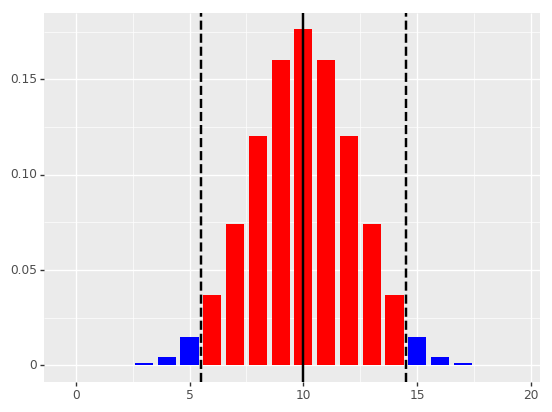

<ggplot: (-9223372029302094094)>

In [4]:
p = ggplot(pmf)
p = p + geom_col(aes(x = 'k', y = 'pr', fill='tail'), width = 0.8)
p = p + geom_vline(xintercept = binom.ppf(0.025, n=20, p=0.5) - 0.5, linetype ='--', size = 1)
p = p + geom_vline(xintercept = binom.ppf(0.975, n=20, p=0.5) + 0.5, linetype ='--', size = 1)
p = p + geom_vline(xintercept = binom.ppf(0.500, n=20, p=0.5) + 0.0, linetype ='-',  size = 1)
p = p + scale_x_continuous(name = '') + scale_y_continuous(name = '')
p = p + scale_fill_manual(guide = False, values = ['red', 'blue'])
p.save('binomial_distribution.pdf', path='results', height=6, width=12, verbose=False)
display(p)

## II. Confidence intervals for the probability

The most naive way to find confidence intervals for binomial distribution is following:
* Define a statistical test for all possible values of $p\in[0,1]$ by computing $2.5\%$ and $97.5\%$ quantiles
* Tabulate for each integer value what tests are passed and extent corresponding parameter set into an interval  


### Tabulate quantiles for all parameter values

In [5]:
n = 20
tdf = DataFrame(index = range(11)).assign(p = lambda df: df.index.values/(len(df)-1))
tdf['q1'] = tdf['p'].apply(lambda p: binom.ppf(0.025, n, p))
tdf['q2'] = tdf['p'].apply(lambda p: binom.ppf(0.975, n, p))

# Lets correct obvious scipy error
tdf.loc[0, 'q1'] = 0
display(tdf)    

,p,q1,q2
0,0.0,0.0,0.0
1,0.1,0.0,5.0
2,0.2,1.0,8.0
3,0.3,2.0,10.0
4,0.4,4.0,12.0
5,0.5,6.0,14.0
6,0.6,8.0,16.0
7,0.7,10.0,18.0
8,0.8,12.0,19.0
9,0.9,15.0,20.0


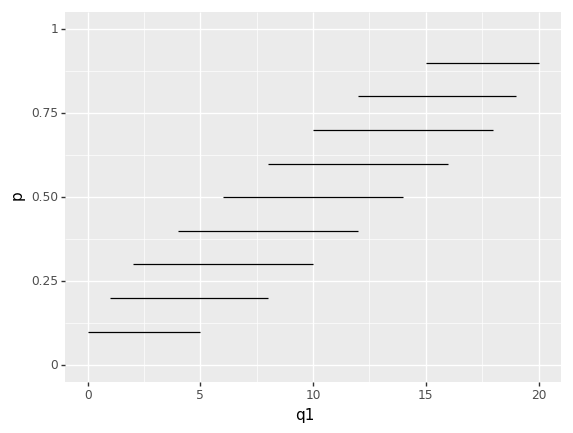

<ggplot: (-9223372029302101132)>

In [6]:
p = ggplot(tdf)
p + geom_segment(aes(x = 'q1', xend = 'q2', y = 'p', yend = 'p')) 

### Tabulate accepted hypoteses for each observation

In [7]:
df =[None] * 21
for k in range(21):
    df[k] = DataFrame({'observed_k':k, 'accepted_p': tdf.loc[(tdf['q1'] <= k) & (k<= tdf['q2']), 'p']})
df = pd.concat(df, ignore_index=True)


# As we use finite grid we must extend the interval to next grid point  
sdf = (df.groupby(['observed_k']).aggregate([min, max])
       .pipe(lambda df: reset_column_index(df, 0))
       .reset_index()
       .assign(maxp = lambda df: df['max'] + 0.1)
       .assign(minp = lambda df: df['min'] - 0.1))

mdisplay([head(df), head(sdf)], ['Accepted parameters', 'Extended intervals'])

Accepted parameters Extended intervals 
 
 
 observed_k 
 accepted_p 
 
 
 
 
 0 
 0.0 
 
 
 0 
 0.1 
 
 
 1 
 0.1 
 
 
 1 
 0.2 
 
 
 2 
 0.1 
 
 
 
 
 
 observed_k 
 min 
 max 
 maxp 
 minp 
 
 
 
 
 0 
 0.0 
 0.1 
 0.2 
 -0.1 
 
 
 1 
 0.1 
 0.2 
 0.3 
 0.0 
 
 
 2 
 0.1 
 0.3 
 0.4 
 0.0 
 
 
 3 
 0.1 
 0.3 
 0.4 
 0.0 
 
 
 4 
 0.1 
 0.4 
 0.5 
 0.0

### Visualisation of the search procedure

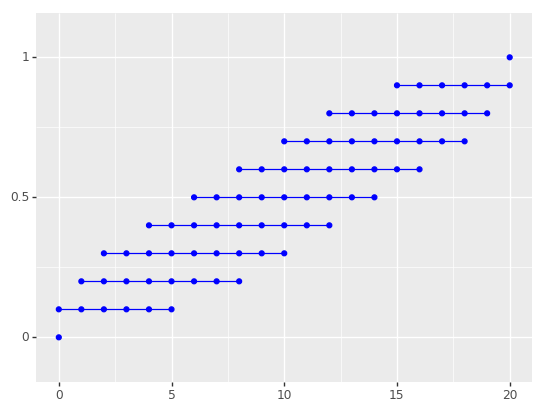

<ggplot: (7552905620)>

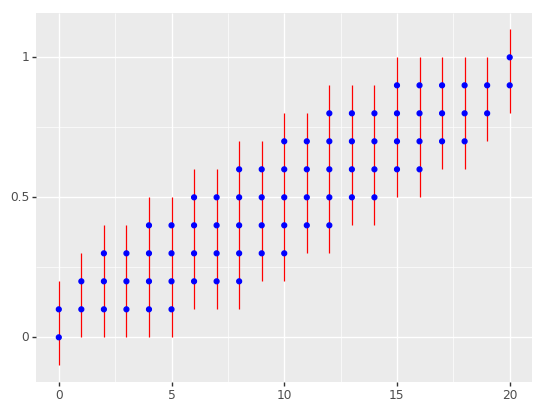

<ggplot: (-9223372029301870290)>

In [8]:
p = ggplot(tdf)
p = p + geom_segment(aes(x = 'q1', xend = 'q2', y = 'p', yend = 'p'), color = 'blue') 
p = p + geom_point(aes(x = 'observed_k', y = 'accepted_p'), color = 'blue', data = df)
p = p + scale_x_continuous(name = '')
p = p + scale_y_continuous(name = '', limits=(-0.1, 1.1), breaks = [0, 0.5, 1.0])
p.save('bin_conf_intervals_i.pdf', path='results', height=6, width=6, verbose=False)
display(p)


p = ggplot(df)
p = p + geom_segment(aes(x = 'observed_k', xend = 'observed_k', y='minp', yend ='maxp'), color = 'red', data=sdf)
p = p + geom_point(aes(x = 'observed_k', y = 'accepted_p'), color = 'blue')
p = p + scale_x_continuous(name = '')
p = p + scale_y_continuous(name = '', limits=(-0.1, 1.1), breaks = [0, 0.5, 1.0])
p.save('bin_conf_intervals_ii.pdf', path='results', height=6, width=6, verbose=False)
display(p)

## III. What does the significance level mean?

The significance level is a subtle concept. Most importantly, **the significance ** 

In [ ]:
https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_confint.html

In [10]:
from statsmodels.stats.proportion import proportion_confint

In [97]:
r = 40

# Confidence intervals at sihnificance level 5%
obs1 = (DataFrame({'k': binom.rvs(n=20, p=0.5, size=r)})
        .assign(q1 = lambda df: df['k'].apply(
                            lambda k: proportion_confint(k, nobs=n, alpha = 0.05, method = 'binom_test')[0]))
        .assign(q2 = lambda df: df['k'].apply(
                            lambda k: proportion_confint(k, nobs=n, alpha = 0.05, method = 'binom_test')[1]))
        .assign(fails = lambda df: (0.5 < df['q1']) | (df['q2'] < 0.5))
        .assign(alpha = r'$\alpha =5\%$')
        .assign(y = lambda df: (df.index.values + 1)/len(df.index))
        )

# Confidence intervals at sihnificance level 20%
obs2 = (obs1[['k']]
        .assign(q1 = lambda df: df['k'].apply(
                                lambda k: proportion_confint(k, nobs=n, alpha = 0.20, method = 'binom_test')[0]))
        .assign(q2 = lambda df: df['k'].apply(
                                lambda k: proportion_confint(k, nobs=n, alpha = 0.20, method = 'binom_test')[1]))
        .assign(fails = lambda df: (0.5 < df['q1']) | (df['q2'] < 0.5))
        .assign(alpha = r'$\alpha =20\%$')
        .assign(y = lambda df: (df.index.values + 1)/len(df.index))
)

mdisplay([head(obs1), head(obs2)], ['Large intervals', 'Small intervals'])

Large intervals Small intervals 
 
 
 k 
 q1 
 q2 
 fails 
 alpha 
 y 
 
 
 
 
 8 
 0.208933 
 0.627797 
 False 
 $\alpha =5\%$ 
 0.025 
 
 
 5 
 0.104081 
 0.474569 
 True 
 $\alpha =5\%$ 
 0.050 
 
 
 6 
 0.139554 
 0.525431 
 False 
 $\alpha =5\%$ 
 0.075 
 
 
 9 
 0.244259 
 0.680012 
 False 
 $\alpha =5\%$ 
 0.100 
 
 
 10 
 0.292710 
 0.707290 
 False 
 $\alpha =5\%$ 
 0.125 
 
 
 
 
 
 k 
 q1 
 q2 
 fails 
 alpha 
 y 
 
 
 
 
 8 
 0.261447 
 0.548953 
 False 
 $\alpha =20\%$ 
 0.025 
 
 
 5 
 0.146317 
 0.402008 
 True 
 $\alpha =20\%$ 
 0.050 
 
 
 6 
 0.180364 
 0.451047 
 True 
 $\alpha =20\%$ 
 0.075 
 
 
 9 
 0.303198 
 0.597992 
 False 
 $\alpha =20\%$ 
 0.100 
 
 
 10 
 0.352779 
 0.647221 
 False 
 $\alpha =20\%$ 
 0.125

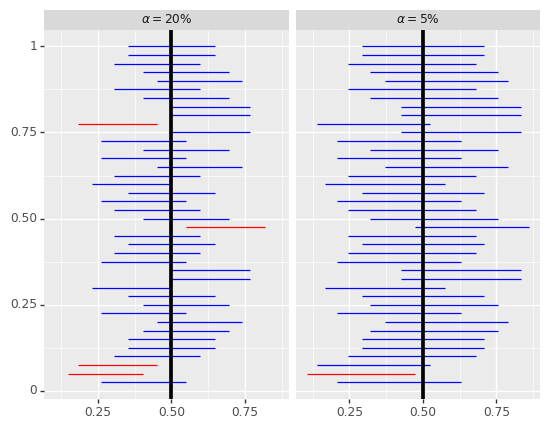

<ggplot: (-9223372036570602394)>

In [98]:
p = ggplot(pd.concat([obs1, obs2]))
p = p + geom_segment(aes(x = 'q1', xend = 'q2', y = 'y', yend='y', color = 'fails'))
p = p + facet_wrap(['alpha'])
p = p + geom_vline(xintercept = 0.5, size = 1.5)
p = p + scale_x_continuous(name = '') + scale_y_continuous(name = '')
p = p + scale_color_manual(guide = False, values = ['blue', 'red'])
p.save('confidence_intervals_example.pdf', path='results', height=6, width=12, verbose=False)
display(p)

# Homework  

In [9]:
%config IPCompleter.greedy=True